|Name|SNR|ANR|
|----|---|----|
|E.A. Teräsaho|1271529|u206957|
|W. Oude Lansink|2000959|u809574|

In [56]:
NAME = "eaterasaho"
COLLABORATORS = "Wisseol"

For this problem set, we'll be using the Jupyter notebook:

![](jupyter.png)

## Table of Contents

1. [Research question](#first-bullet)
2. [Motivation](#second-bullet)
3. [Method](#third-bullet)
4. [Dependencies](#fourth-bullet)
5. [Data](#fifth-bullet)
6. [Preview of the answers](#sixth-bullet)
7. [Main assumptions](#seventh-bullet)
8. [Python code](#eighth-bullet)
9. [Robustness analysis](#ninth-bullet)
10. [Discussion and conclusion](#tenth-bullet)

# Research question <a class="anchor" id="first-bullet"></a>

# Motivation <a class="anchor" id="second-bullet"></a>

# Method <a class="anchor" id="third-bullet"></a>

# Dependencies <a class="anchor" id="fourth-bullet"></a>

In [57]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
# Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow
from tensorflow import set_random_seed
set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.activations import relu, tanh
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')
import os
import pandas_datareader as web

# Data

In [59]:
if os.path.isfile('stocks.csv'): # This row checks if the data is already in .csv format in the repository
    multpl_stocks = pd.read_csv('stocks.csv', header = [0,1], parse_dates=[0], index_col=[0])
    print('Data fetched from repository')

else: # If the data is not in the repository, it will be downloaded
    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') # Collecting S&P 500 tickers from wikipedia
    df = table[0]
    df.to_csv('S&P500-Info.csv')
    df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
    ticker = df['Symbol']
    tickers = ticker.values.tolist()
    tickers = [w.replace('.', '-') for w in tickers]
    multpl_stocks = web.get_data_yahoo(tickers, start = "2010-01-01", end = "2019-12-31") #Row to fetch the data from Yahoo Finance, using the list of tickers
    multpl_stocks.to_csv(r'stocks.csv')
    print('Data dowloaded from Yahoo Finance and saved to repository')
    
multpl_stocks.head()

Data fetched from repository


Attributes  Adj Close                                                         \
Symbols           MMM        ABT ABBV  ABMD        ACN       ATVI       ADBE   
Date                                                                           
2010-01-04  62.895260  20.301096  NaN  8.74  33.719078  10.126624  37.090000   
2010-01-05  62.501301  20.137075  NaN  8.53  33.927479  10.144546  37.700001   
2010-01-06  63.387695  20.248909  NaN  8.40  34.288147  10.090778  37.619999   
2010-01-07  63.433144  20.416655  NaN  8.40  34.256084   9.848815  36.889999   
2010-01-08  63.880119  20.521032  NaN  8.23  34.119835   9.768159  36.689999   

Attributes                              ...     Volume                 \
Symbols      AMD        AAP        AES  ...        XRX       XLNX XYL   
Date                                    ...                             
2010-01-04  9.70  39.223591  10.670638  ...  5112800.0  2824700.0 NaN   
2010-01-05  9.71  38.990475  10.561357  ...  3255800.0  3469700.0 NaN   
2010-01-06  9.57  39.330433  10.452073  ...  2634300.0  6329200.0 NaN   
2010-01-07  9.47  39.320717  10.459881  ...  4508500.0  9252700.0 NaN   
2010-01-08  9.43  39.476143  10.756501  ...  2460100.0  5005800.0 NaN   

Attributes                                                            
Symbols           YUM      ZBRA        ZBH        ZION ZTS CARR OTIS  
Date                                                                  
2010-01-04  2962200.0  168800.0   782400.0   3974600.0 NaN  NaN  NaN  
2010-01-05  3298700.0  168800.0  1718100.0   5605500.0 NaN  NaN  NaN  
2010-01-06  4178900.0  385300.0  1277300.0  12615200.0 NaN  NaN  NaN  
2010-01-07  2452400.0  183600.0  1683500.0  24716800.0 NaN  NaN  NaN  
2010-01-08  3772300.0  266500.0  2149500.0   6903000.0 NaN  NaN  NaN  

[5 rows x 3030 columns]

In [60]:
multpl_stocks.dropna(axis=1, how='any', inplace=True)

# Random stratified sampling

In [61]:
daily_returns = multpl_stocks['Adj Close'].pct_change()

p_vol = daily_returns.std().rename('p_vol')
v_std = multpl_stocks['Volume'].pct_change().std().rename('v_std')

In [62]:
p_vol = p_vol.to_frame()

v_std = v_std.to_frame()

In [63]:
not_dropped = pd.merge(p_vol, v_std, on='Symbols')
not_dropped.dropna(how='any', inplace=True)

In [64]:
q1_vol, q3_vol= np.percentile(sorted(not_dropped['p_vol']),[25,75])

iqr_vol = q3_vol-q1_vol

lower_bound_vol = q1_vol - (1.5*iqr_vol)
upper_bound_vol = q3_vol + (1.5*iqr_vol)

vola = not_dropped['p_vol'][not_dropped['p_vol'].between(lower_bound_vol, upper_bound_vol, inclusive=False)].rename('volu')

q1_volu, q3_volu= np.percentile(sorted(not_dropped['v_std']),[25,75])

iqr_volu = q3_volu-q1_volu

lower_bound_volu = q1_volu - (1.5*iqr_volu)
upper_bound_volu = q3_volu + (1.5*iqr_volu)

volu = not_dropped['v_std'][not_dropped['v_std'].between(lower_bound_volu, upper_bound_volu, inclusive=False)].rename('volu')

In [65]:
vola = vola.to_frame()

volu = volu.to_frame()

dropped = pd.merge(vola, volu, on='Symbols')

In [66]:
dropped['price_rank'] = dropped.volu_x.rank()
dropped['volume_rank'] = dropped.volu_y.rank()

In [67]:
dropped.loc[dropped['price_rank'] <= 420, 'price'] = 3
dropped.loc[dropped['price_rank'] <= 315, 'price'] = 2
dropped.loc[dropped['price_rank'] <= 210, 'price'] = 1
dropped.loc[dropped['price_rank'] <= 105, 'price'] = 0


In [68]:
dropped.loc[dropped['volume_rank'] <= 420, 'volume'] = 3
dropped.loc[dropped['volume_rank'] <= 315, 'volume'] = 2
dropped.loc[dropped['volume_rank'] <= 210, 'volume'] = 1
dropped.loc[dropped['volume_rank'] <= 105, 'volume'] = 0

In [69]:
drop_count = dropped.groupby(['price', 'volume'])['price'].count()

In [70]:
stratified_sample = list(map(lambda a : dropped[
    (dropped['price'] == drop_count.index[a][0]) &
    (dropped['volume'] == drop_count.index[a][1])].sample(frac=0.021, random_state = 121), range(len(drop_count))))

stratified_sample = pd.concat(stratified_sample)

stratified_sample

,volu_x,volu_y,price_rank,volume_rank,price,volume
Symbols,,,,,,
PSA,0.012409,0.402029,76.0,15.0,0.0,0.0
DTE,0.010090,0.476314,10.0,129.0,0.0,1.0
UNP,0.014761,0.410672,168.0,24.0,1.0,0.0
SHW,0.013620,0.526458,122.0,215.0,1.0,2.0
MA,0.015943,0.481010,228.0,141.0,2.0,1.0
PNR,0.016291,0.639691,240.0,336.0,2.0,3.0
TPR,0.020671,0.523748,357.0,211.0,3.0,2.0
TTWO,0.022243,0.666671,391.0,348.0,3.0,3.0


In [71]:
stratified_sample.to_csv('strat_samp.csv')

In [72]:
adj_close = multpl_stocks['Adj Close'][stratified_sample.index]
volume = multpl_stocks['Volume'][stratified_sample.index]
df = pd.merge(adj_close, volume, on='Date', suffixes=('_adj', '_volume'))

In [73]:
adj_close.to_csv('adj_close.csv')

In [74]:
adj = pd.read_csv(r'adj_close.csv', header = [0], parse_dates=[0], index_col=[0])
stratified_sample = pd.read_csv(r'strat_samp.csv')

In [75]:
ticlist = list(adj_close.columns)

In [76]:
def split(dataframe, border1, border2):
    return dataframe.loc[:border1], dataframe.loc[border1:border2], dataframe.loc[border2:]

df_new = {}
for i in ticlist:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Val"], df_new[i]["Test"] = split(adj_close[i], "1-1-2016", "1-1-2018")

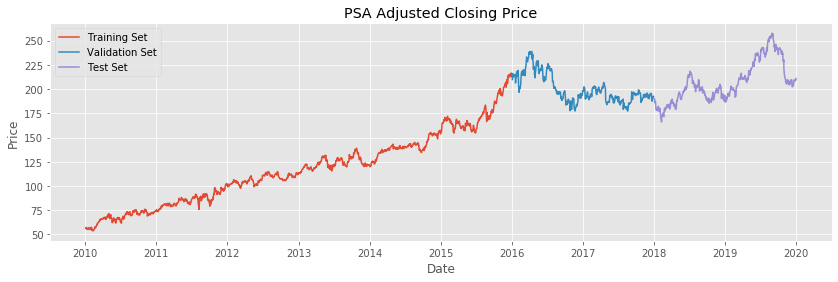

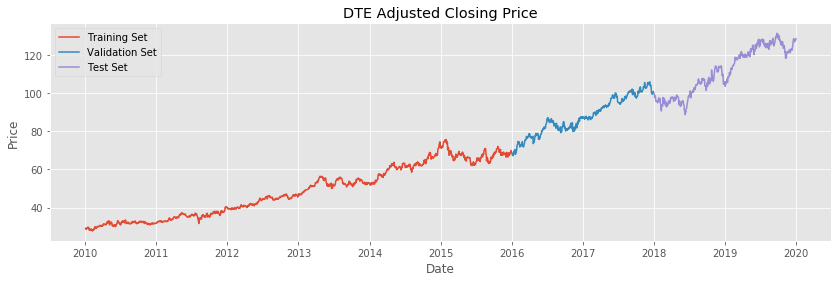

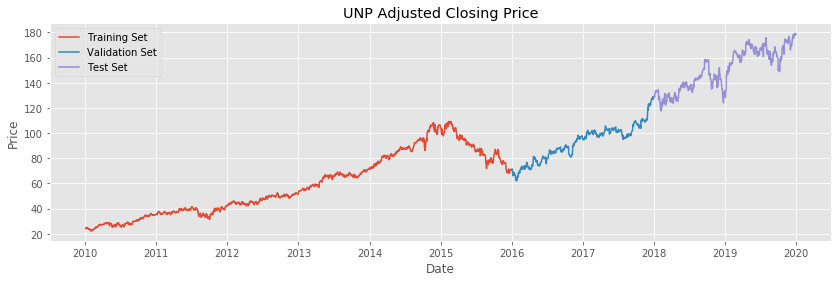

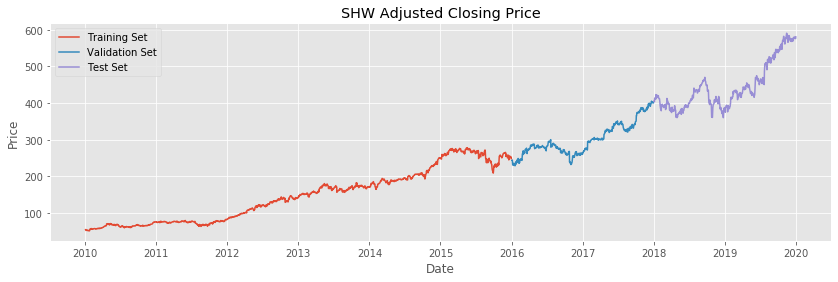

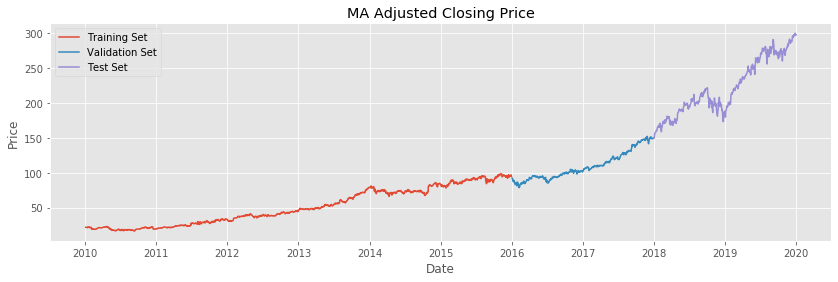

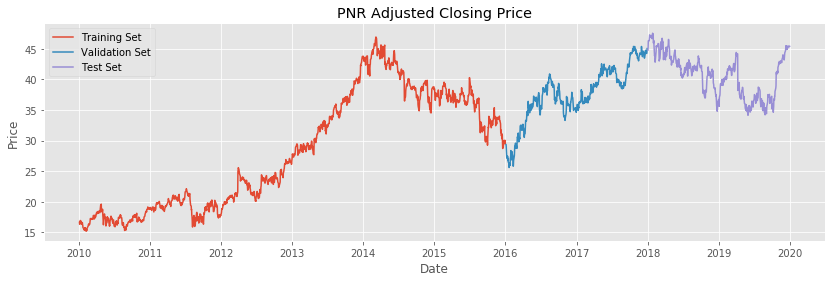

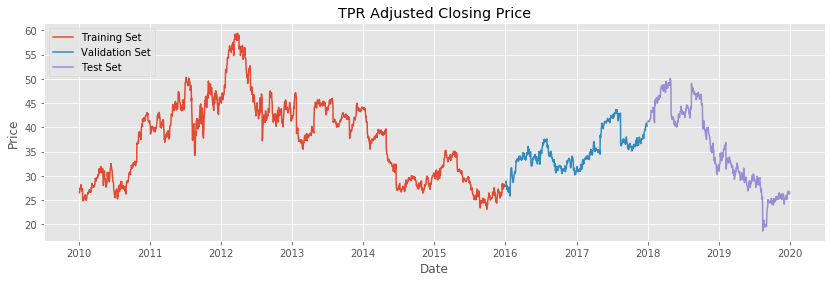

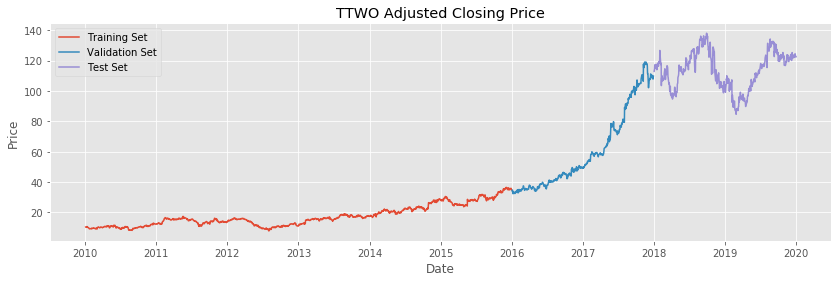

In [77]:
for i in ticlist:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Val"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Validation Set", "Test Set"], loc='upper left')
    plt.title(i + " Adjusted Closing Price")

In [78]:
# Scaling the training set
transform_train = {}
transform_val = {}
transform_test = {}
scaler = {}

for num, i in enumerate(ticlist):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Val"])
    a2 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    a2 = a2.reshape(a2.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_val[i] = sc.fit_transform(a1)
    transform_test[i] = sc.fit_transform(a2)
    scaler[i] = sc
    
    
del a0
del a1
del a2

In [79]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_val.keys():
    print(i, transform_val[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

PSA (1510, 1)
DTE (1510, 1)
UNP (1510, 1)
SHW (1510, 1)
MA (1510, 1)
PNR (1510, 1)
TPR (1510, 1)
TTWO (1510, 1)


PSA (503, 1)
DTE (503, 1)
UNP (503, 1)
SHW (503, 1)
MA (503, 1)
PNR (503, 1)
TPR (503, 1)
TTWO (503, 1)


PSA (503, 1)
DTE (503, 1)
UNP (503, 1)
SHW (503, 1)
MA (503, 1)
PNR (503, 1)
TPR (503, 1)
TTWO (503, 1)


In [80]:
trainset = {}
valset = {}
testset = {}
for j in ticlist:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,1510):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    valset[j] = {}
    X_val = []
    y_val = []    
    for i in range(60, 503):
        X_val.append(transform_val[j][i-60:i,0])
        y_val.append(transform_val[j][i,0])
    X_val, y_val = np.array(X_val), np.array(y_val)
    valset[j]["X"] = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    valset[j]["y"] = y_val
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 503):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [81]:
arr_buff = []
for i in ticlist:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_val"] = valset[i]["X"].shape
    buff["y_val"] = valset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=ticlist)

,X_train,y_train,X_val,y_val,X_test,y_test
PSA,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
DTE,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
UNP,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
SHW,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
MA,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
PNR,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
TPR,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
TTWO,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"


In [82]:
%%time
# The LSTM architecture
lstm = Sequential()
# First LSTM layer with Dropout regularisation
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm.add(Dropout(0.2))
# Second LSTM layer
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.2))
# Third LSTM layer
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.5))
# Fourth LSTM layer
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.5))
# The output layer
lstm.add(Dense(units=1))

# Compiling the RNN
lstm.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in ticlist:
    print(str(ticlist.index(i)+1), ". Fitting to", i)
    lstm.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200, validation_data=[valset[i]["X"], valset[i]["y"]])

1 . Fitting to PSA
Train on 1450 samples, validate on 443 samples
Epoch 1/10
1450/1450 [==============================] - 6s 4ms/step - loss: 0.0786 - val_loss: 0.0175
Epoch 2/10
1450/1450 [==============================] - 7s 5ms/step - loss: 0.0151 - val_loss: 0.0245
Epoch 3/10
1450/1450 [==============================] - 5s 4ms/step - loss: 0.0200 - val_loss: 0.0121
Epoch 4/10
1450/1450 [==============================] - 5s 3ms/step - loss: 0.0181 - val_loss: 0.0131
Epoch 5/10
1450/1450 [==============================] - 5s 3ms/step - loss: 0.0165 - val_loss: 0.0135
Epoch 6/10
1450/1450 [==============================] - 5s 3ms/step - loss: 0.0121 - val_loss: 0.0135
Epoch 7/10
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0166 - val_loss: 0.0117
Epoch 8/10
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0143 - val_loss: 0.0196
Epoch 9/10
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0114 - val_loss: 0.0179
Epoch 10/10
1450

1450/1450 [==============================] - 4s 3ms/step - loss: 0.0044 - val_loss: 9.5116e-04
Epoch 7/10
1450/1450 [==============================] - 5s 4ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 8/10
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0043 - val_loss: 9.1209e-04
Epoch 9/10
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0049 - val_loss: 8.7306e-04
Epoch 10/10
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0034 - val_loss: 0.0011
CPU times: user 11min 10s, sys: 3min 44s, total: 14min 55s
Wall time: 5min 36s


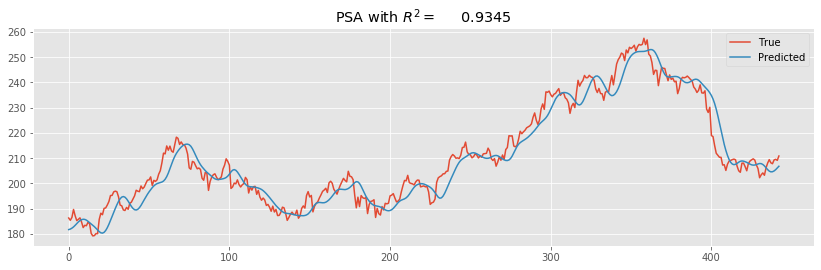

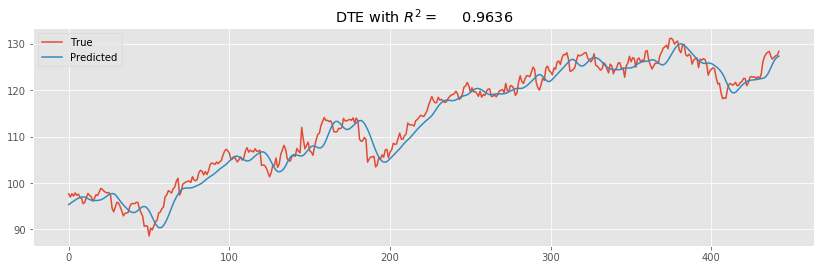

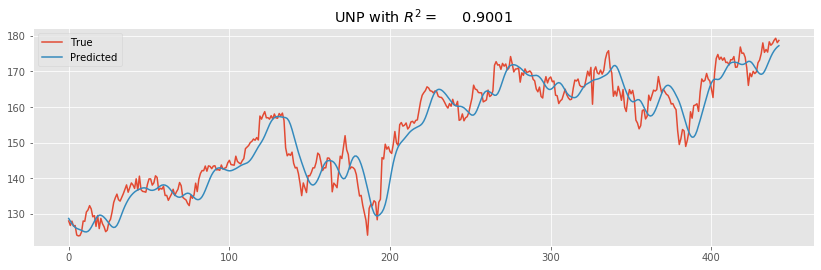

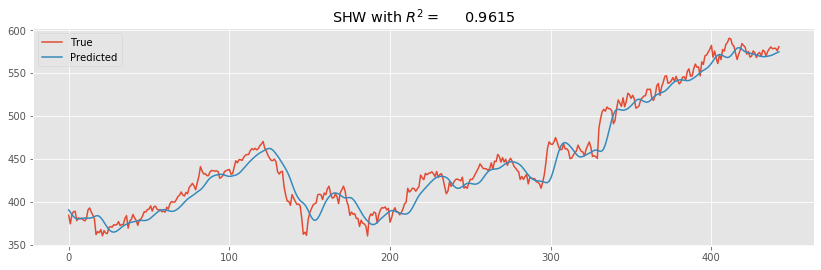

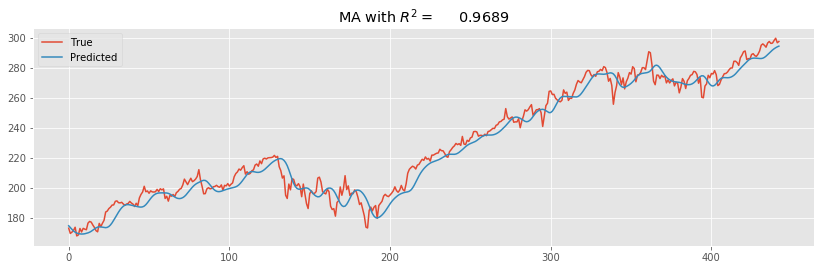

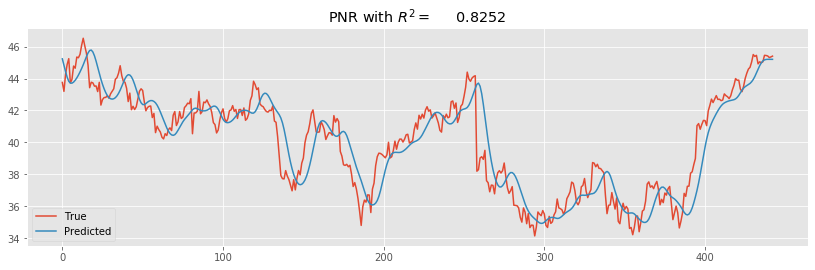

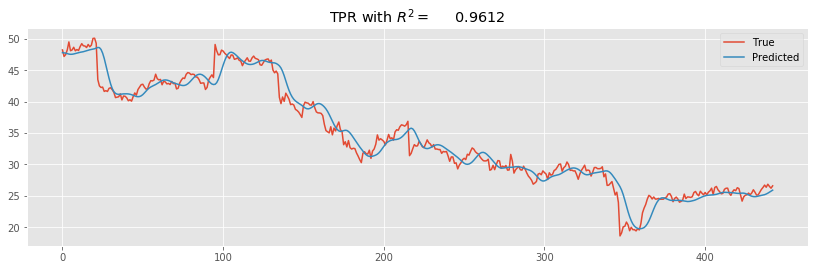

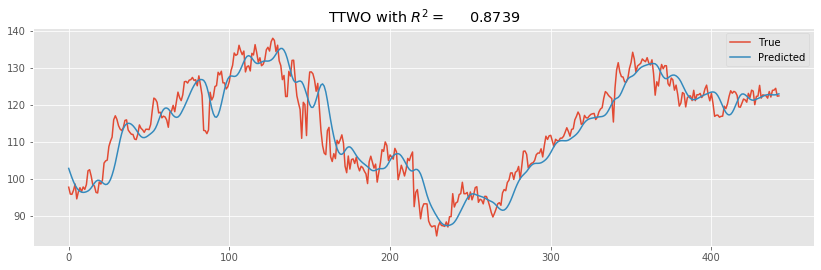

In [83]:
pred_result = {}
r = {}
for i in ticlist:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(lstm.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    r[i] = r2_score(pred_result[i]["True"],pred_result[i]["Pred"])
    plt.figure(figsize=(14,4))
    plt.title("{} with $R^2 =$ {:10.4f}".format(i,r[i]))
    plt.plot(y_true)
    plt.plot(y_pred)
    plt.legend(["True", "Predicted"])

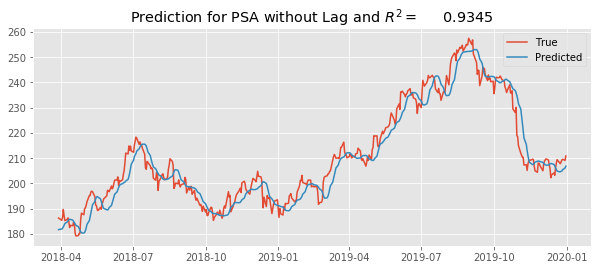

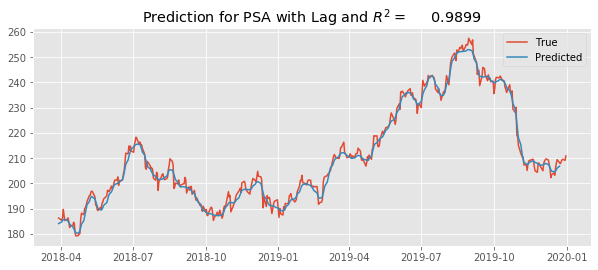

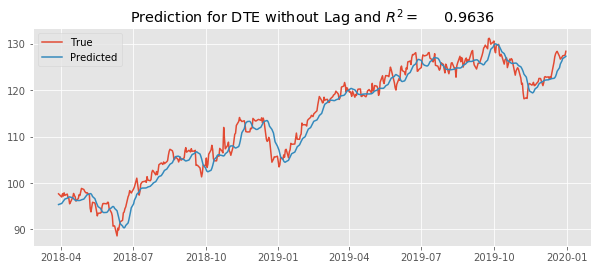

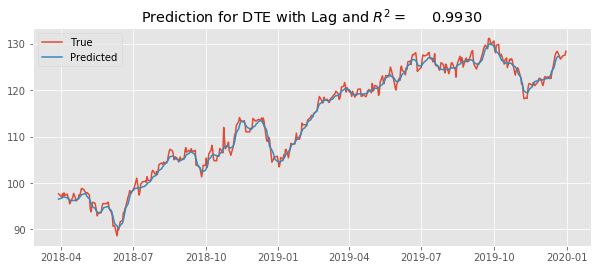

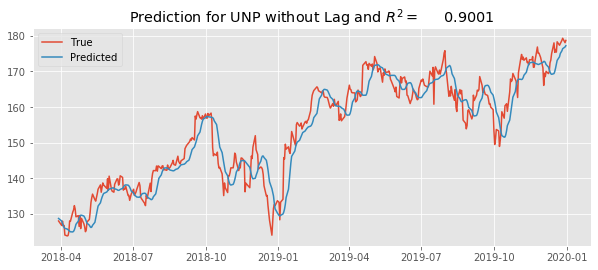

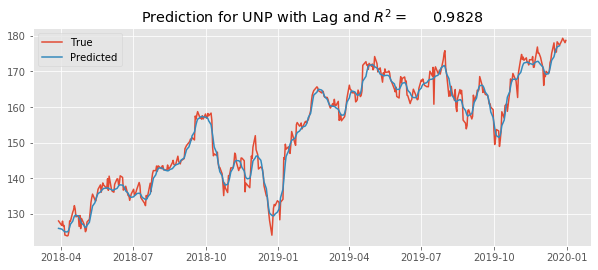

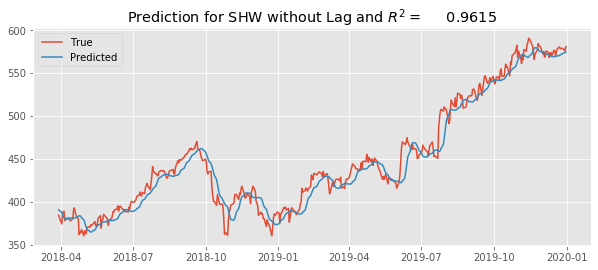

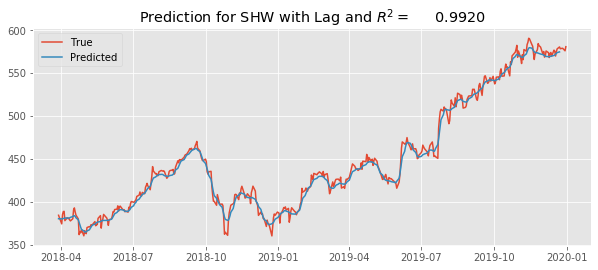

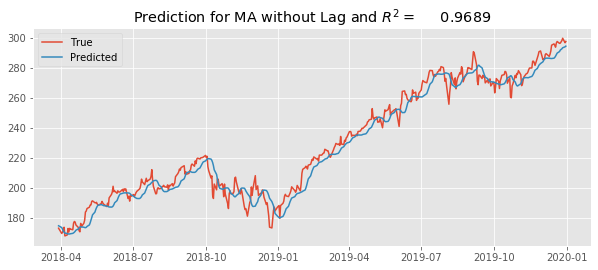

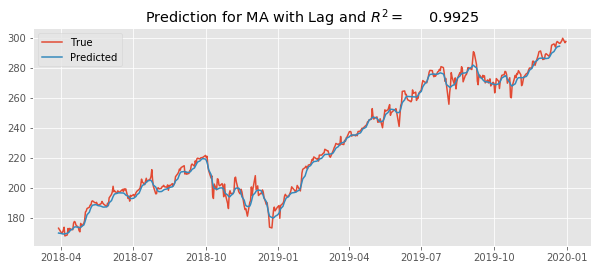

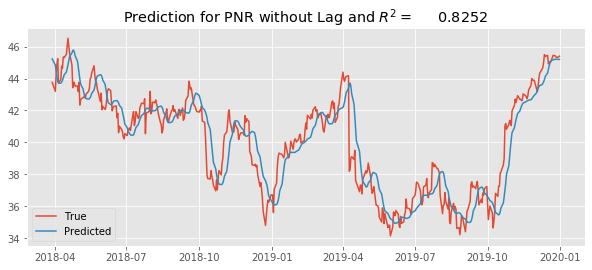

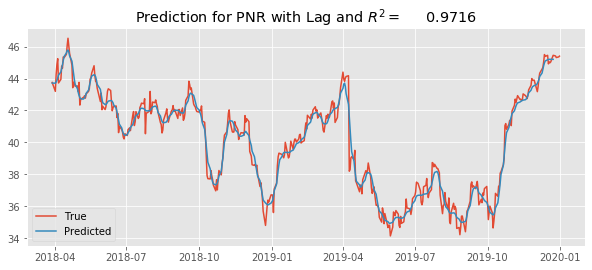

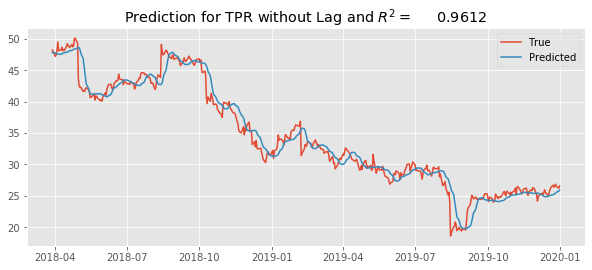

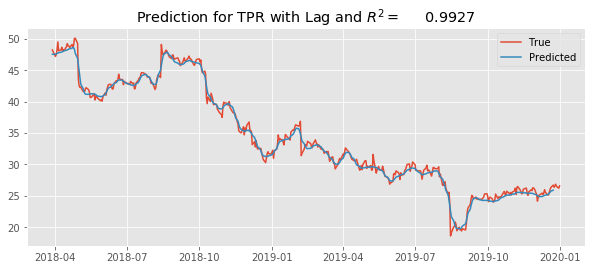

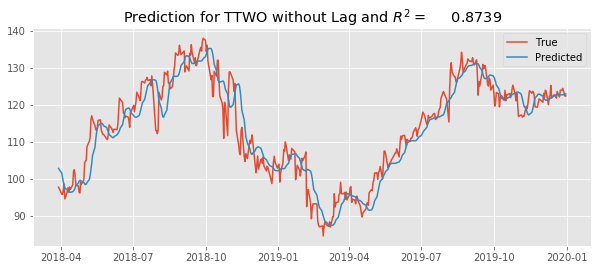

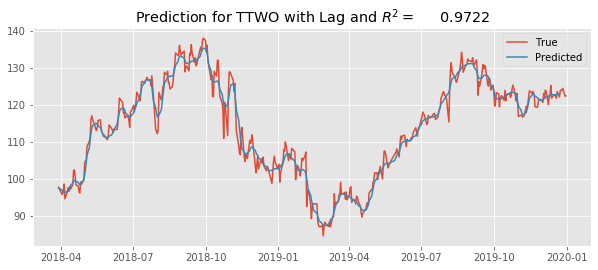

In [84]:
time_index = df_new["PSA"]["Test"][60:].index
df_pred = {}
df_true = {}
df_pred_lag = {}
r = {}
Rsquared_lag = {}
for i in ticlist:  
    
    df_pred[i] = pd.Series(scaler[i].inverse_transform(lstm.predict(testset[i]["X"])).reshape(-1), index=time_index)
    df_true[i] = pd.Series(scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1)).reshape(-1), index=time_index)
    df_pred_lag[i] = df_pred[i].shift(-5)
    r[i] = r2_score(df_true[i],df_pred[i])
    plt.figure(figsize=(10,4))
    plt.title("Prediction for {} without Lag and $R^2 =$ {:10.4f}".format(i, r[i]))
    plt.plot(df_true[i])
    plt.plot(df_pred[i])
    plt.legend(["True", "Predicted"])

    Rsquared_lag[i] = r2_score(np.array(df_true[i][:-5]), np.array(df_pred_lag[i][:-5]))
    plt.figure(figsize=(10,4))
    plt.title("Prediction for {} with Lag and $R^2 =$ {:10.4f}".format(i,Rsquared_lag[i] ))
    plt.plot(df_true[i])
    plt.plot(df_pred_lag[i])
    plt.legend(["True", "Predicted"])

In [85]:
R_squared = {}

for i in ticlist:
    R_squared[i] = r2_score(df_true[i],df_pred[i])

    
r_square = pd.DataFrame(R_squared.items())
r_square.columns = ['Symbols', 'R^2']
r_square.set_index('Symbols', inplace = True)
corr_df = r_square.merge(p_vol, how='left', left_index=True, right_index=True)
corr_df = corr_df.merge(v_std, how ='left', left_index = True, right_index = True )
corr_df

,R^2,p_vol,v_std
Symbols,,,
PSA,0.934549,0.012409,0.402029
DTE,0.963607,0.010090,0.476314
UNP,0.900142,0.014761,0.410672
SHW,0.961498,0.013620,0.526458
MA,0.968867,0.015943,0.481010
PNR,0.825155,0.016291,0.639691
TPR,0.961200,0.020671,0.523748
TTWO,0.873914,0.022243,0.666671


In [86]:
corr_df = r_square.merge(p_vol, how='left', left_index=True, right_index=True)
corr_df = corr_df.merge(v_std, how ='left', left_index = True, right_index = True )
corr_df.corr()

,R^2,p_vol,v_std
R^2,1.000000,-0.336515,-0.590061
p_vol,-0.336515,1.000000,0.643722
v_std,-0.590061,0.643722,1.000000


# Robustness Analysis <a class="anchor" id="ninth-bullet"></a>

In [87]:
%%time
# The RNN architecture
rnn = Sequential()
# First RNN layer with Dropout regularisation
rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn.add(Dropout(0.2))
# Second RNN layer
rnn.add(SimpleRNN(units=50, return_sequences=True))
rnn.add(Dropout(0.2))
# Third RNN layer
rnn.add(SimpleRNN(units=50, return_sequences=True))
rnn.add(Dropout(0.5))
# Fourth RNN layer
rnn.add(SimpleRNN(units=50))
rnn.add(Dropout(0.5))
# The output layer
rnn.add(Dense(units=1))

# Compiling the RNN
rnn.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in ticlist:
    print(str(ticlist.index(i)+1), "Fitting to", i)
    rnn.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200, validation_data=[valset[i]["X"], valset[i]["y"]])

1 Fitting to PSA
Train on 1450 samples, validate on 443 samples
Epoch 1/10
1450/1450 [==============================] - 3s 2ms/step - loss: 1.5361 - val_loss: 0.1885
Epoch 2/10
1450/1450 [==============================] - 1s 942us/step - loss: 1.1755 - val_loss: 0.3583
Epoch 3/10
1450/1450 [==============================] - 1s 827us/step - loss: 0.9449 - val_loss: 0.4414
Epoch 4/10
1450/1450 [==============================] - 1s 880us/step - loss: 0.8549 - val_loss: 0.0314
Epoch 5/10
1450/1450 [==============================] - 1s 930us/step - loss: 0.6701 - val_loss: 0.0895
Epoch 6/10
1450/1450 [==============================] - 1s 832us/step - loss: 0.6388 - val_loss: 0.0647
Epoch 7/10
1450/1450 [==============================] - 1s 795us/step - loss: 0.5931 - val_loss: 0.1745
Epoch 8/10
1450/1450 [==============================] - 1s 824us/step - loss: 0.4958 - val_loss: 0.1741
Epoch 9/10
1450/1450 [==============================] - 1s 865us/step - loss: 0.4370 - val_loss: 0.0561
Ep

1450/1450 [==============================] - 1s 779us/step - loss: 0.0061 - val_loss: 0.0015
Epoch 5/10
1450/1450 [==============================] - 1s 773us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 6/10
1450/1450 [==============================] - 1s 769us/step - loss: 0.0050 - val_loss: 0.0026
Epoch 7/10
1450/1450 [==============================] - 1s 777us/step - loss: 0.0060 - val_loss: 5.5429e-04
Epoch 8/10
1450/1450 [==============================] - 1s 762us/step - loss: 0.0040 - val_loss: 0.0014
Epoch 9/10
1450/1450 [==============================] - 1s 779us/step - loss: 0.0053 - val_loss: 6.4035e-04
Epoch 10/10
1450/1450 [==============================] - 1s 774us/step - loss: 0.0046 - val_loss: 7.5565e-04
CPU times: user 3min 18s, sys: 54.2 s, total: 4min 13s
Wall time: 1min 39s


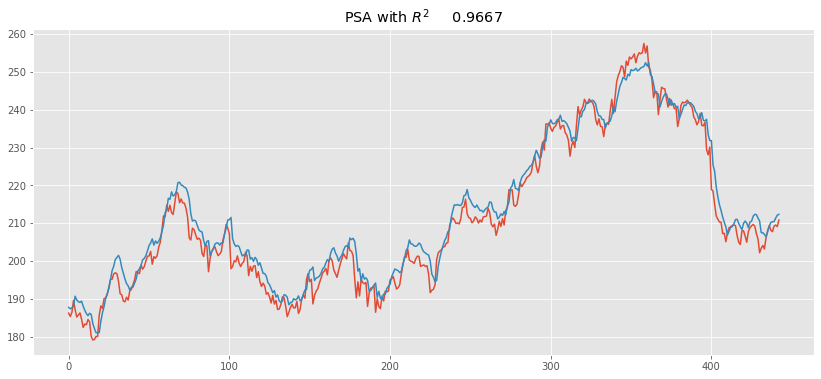

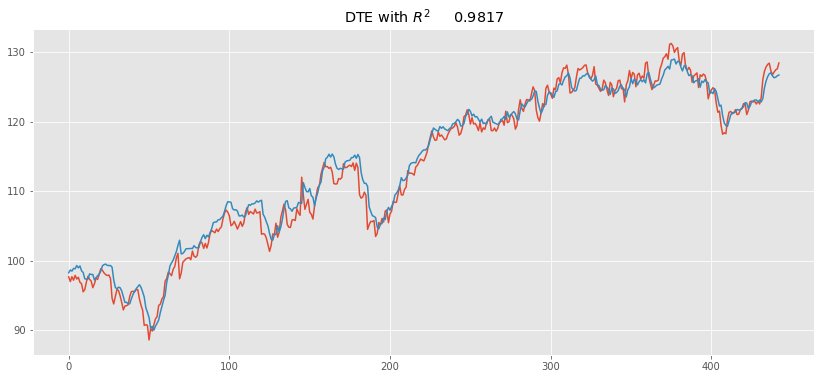

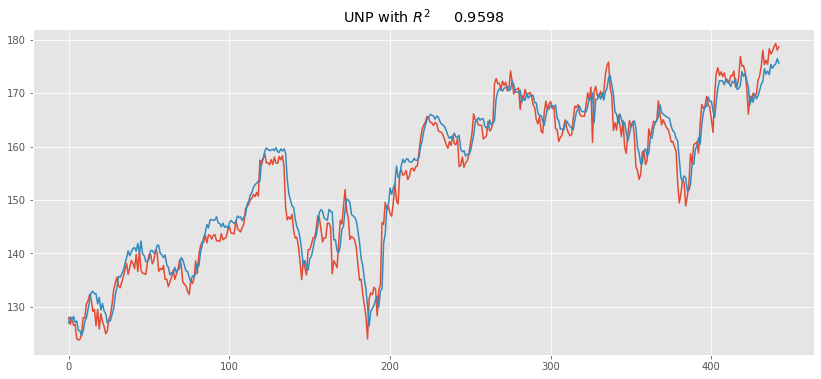

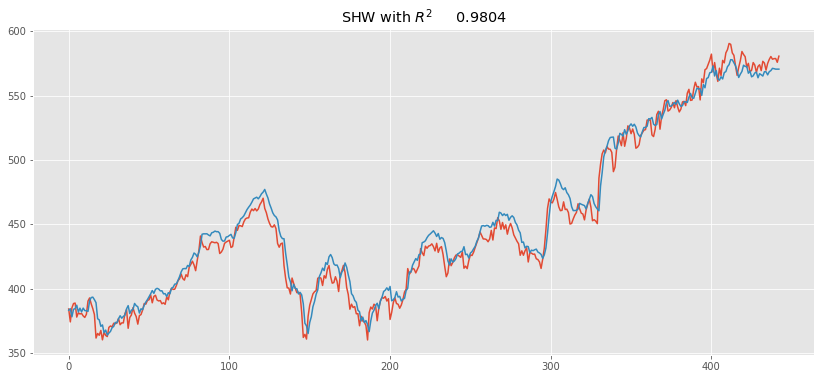

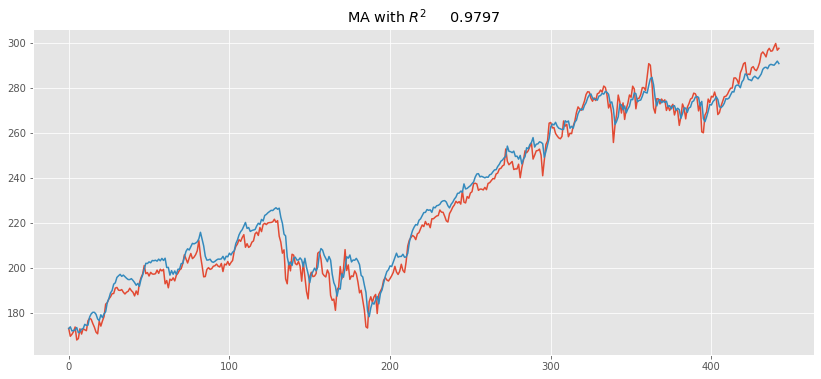

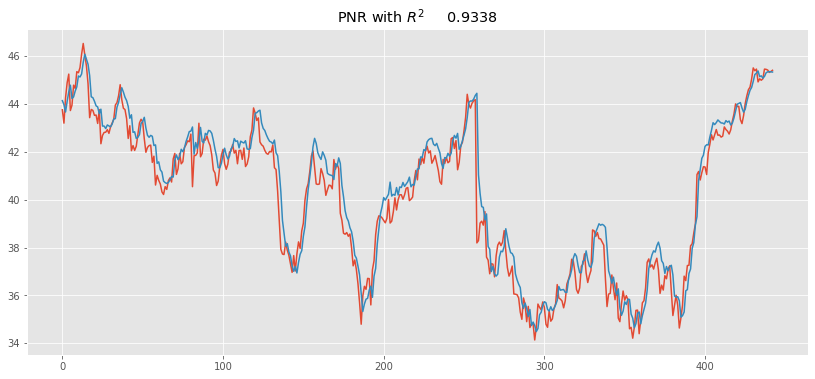

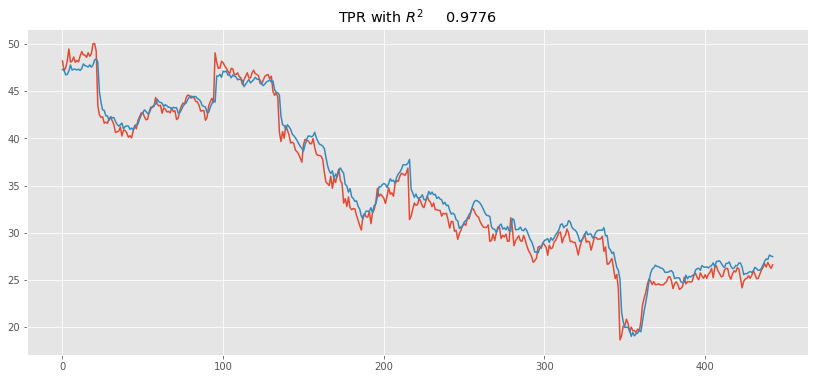

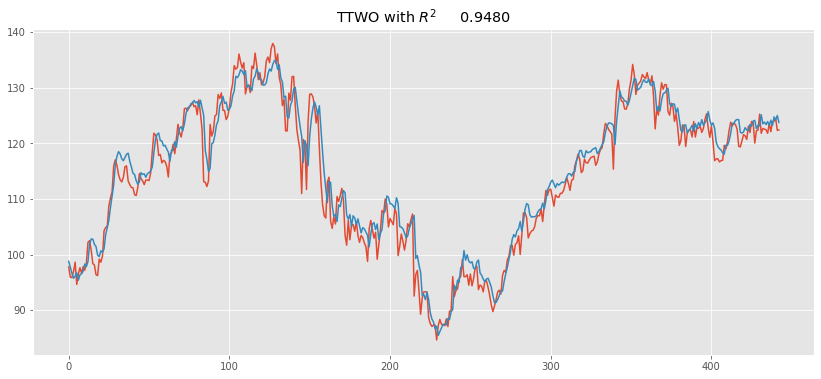

In [88]:
pred_result = {}
for i in ticlist:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(rnn.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    r = r2_score(pred_result[i]["True"],pred_result[i]["Pred"])
    plt.figure(figsize=(14,6))
    plt.title("{} with $R^2$ {:10.4f}".format(i,r))
    plt.plot(y_true)
    plt.plot(y_pred)